# CS323 Project 4: Generative Models

<button disabled>

**Author:** Hasan Abed Al Kader Hammoud, Guocheng Qian, Modar Alfadly, and Shuming Liu

**Due Date:** 25 April 2023 @ 11:59 PM

</button>

In [ ]:
# Student Name: 
# KAUST ID: 
# Degree: 
# Major: 

To setup a conda environment for this project, just run the following commands:

```shell
source $(conda info --base)/etc/profile.d/conda.sh
conda create -n cs323 python=3.9.2 -y
conda activate cs323

conda install pytorch=1.8.1 torchvision=0.9.1 torchaudio=0.8.1 cudatoolkit=11.1 -c pytorch -c conda-forge -y
conda install jupyter=1.0.0 -y  # to edit this file
conda install matplotlib=3.3.4 -y  # for plotting
conda install tqdm=4.59.0 -y  # for a nice progress bar
conda install tensorboard=2.4.0 -y  # to use tensorboard

pip install jupyter_http_over_ws  # for Google Colab
jupyter serverextension enable --py jupyter_http_over_ws  # Google Colab
```

In the previous projects, you learned the basics of deep learning; data loading and processing along with model building, training, and evaluation. In the process, you learned how to tackle few computer vision applications; regression, classification, semantic segmentation, object detection, and video classification. However, all the models that we trained so far fall under the discriminative type (predict something given input data). We will introduce you in this project to generative models (learn the underlying data distribution or how to sample).

Before you start this project, you are highly encouraged to watch this [introductory video](https://www.youtube.com/watch?v=BUNl0To1IVw&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=4) and go through this [notebook](https://bit.ly/dl_for_cv_07).

In [ ]:
from pathlib import Path

from PIL import Image
import matplotlib.pyplot as plt

import tensorboard
from tqdm.notebook import tqdm

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid


What do we mean by data distribution? Let's define it loosely here. The idea is to get an intuition instead of defining it fromally.

Think about all $200 \times 200$ RGB colored images. They have $40000$ pixels each of which has $3$ color channels that can be in the range $[0, 255]$. This means there is $256^{3 \times 200 \times 200} \approx 10^{288988}$ unique images. This number is ridiculously large; the estimated number of atoms in the observable universe is only between $10^{78}$ and $10^{82}$. Now, let's think of all $200 \times 200$ RGB colored images that only have cats in them. These images are a subset of all images but they are still virtually infinite; there are hundreds of cat breeds, millions of cats in the world, different possible angles, lighting, and poses to take cat pictures. However, we can still recognize a cat image instantly since we have developed a mental image (an implicit representation) of what cats look like. We have few properties and characteristics in mind that define cats to us like color, breed, age, ..., etc. For example, it is not hard to imagine an orange tabby kitten. We call these properties latent representation.

[This](https://blog.insightdatascience.com/generating-custom-photo-realistic-faces-using-ai-d170b1b59255) is an example of a generative model that was trained on human faces with a latent representation that can control $21$ different properties:

![](https://miro.medium.com/max/1176/1*LZp9nkzbSk8v6cpwp8CD8g.gif)

If we looked at the images as vectors (i.e., $\mathbf{x} \in [0, 1]^{3 \times 200 \times 200}$), we will find that cat images are concentrated in few regions in this space. The probability $p(\mathbf{x})$ of finding a cat in any location is defined by the density of cat images in that location. If an image $\mathbf{x}$ is close to or surrounded by many cat images, we would say that the probability that $\mathbf{x}$ is a cat image is high ($p(\mathbf{x})$ is close to $1$). Otherwise, the probability should be low ($p(\mathbf{x})$ is close to $0$). This way we defined $p(\mathbf{x})$ as the cat distribution. We can also consider a latent vector $\mathbf{z}$ (encoding color, breed, age, ...) where it has a prior distribution $p(\mathbf{z})$. Similar intuition to $p(\mathbf{x})$ still applies to $p(\mathbf{z})$; cats are distributed in the latent space (e.g., different cat breeds live longer than others). It is much more convenient to work with the latent vector $\mathbf{z}$ than the original image $\mathbf{x}$ since all the information is [distilled in a samller representation](https://deepai.org/machine-learning-glossary-and-terms/manifold-hypothesis). A latent-based generative model is a model that tries to learn how to decode a latent vector to an image and vice versa (i.e., encode an image as a latent vector). The encoder takes an image $\mathbf{x}$ and gives you a latent vector $\mathbf{z}$ (color, breed, age, ...). The decoder takes a latent vector $\mathbf{z}$ to generate an image $\mathbf{x}$. Basically, we want a way to learn the joint distribution $p(\mathbf{x}, \mathbf{z})$.

$$p(\mathbf{x}, \mathbf{z}) = \overset{\text{encoder}}{\overbrace{p(\mathbf{z}|\mathbf{x})}}p(\mathbf{x}) = \overset{\text{decoder}}{\overbrace{p(\mathbf{x}|\mathbf{z})}}\underset{\text{prior}}{\underbrace{p(\mathbf{z})}}$$

The expansion is by [Bayes rule](https://en.wikipedia.org/wiki/Bayes%27_theorem). If we have an encoder and a decoder with the prior, we have modeled the data distribution $p(\mathbf{x})$. If I encoded a cat image and gave you the latent vector only like (a blue cat), you would know that it is unlikely since you know $p(\mathbf{z})$ which doesn't have many blue cats. I can also generate images by sampling (generating) a random latent vector and use the decoder to generate a new image.

To better understand the concepts of prior read the following blog [Priors](https://towardsdatascience.com/bayesian-method-1-1cbdb1e6b4).

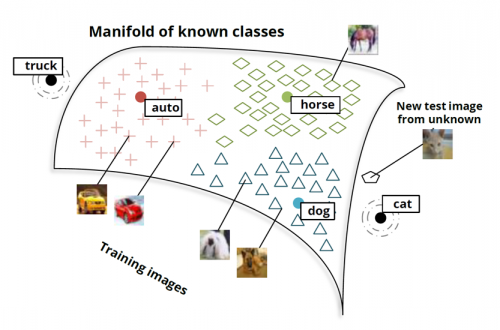

In [ ]:
class FFHQThumbnails(Dataset):
    """Flickr-Faces-HQ Dataset (FFHQ)

    download thumbnails128x128 from https://github.com/NVlabs/ffhq-dataset
    the dataset is available in Ibex (but the large version only 1024x1024)
    """
    def __init__(self, root_dir=None):
        if root_dir is None:
            root_dir = Path(torch.hub.get_dir()) / 'datasets/FFHQ'
        self.root_dir = Path(root_dir)
        if not (self.root_dir / 'thumbnails128x128').exists():
            msg = f'put the folder thumbnails128x128 in {self.root_dir}'
            raise FileNotFoundError(msg)
        self.images = list(self.root_dir.glob('thumbnails128x128/*/*.png'))
        assert len(self.images) == 70000, f'found {len(self.images)} images'

    def __getitem__(self, index):
        # there is not target we only need the image
        return TF.to_tensor(Image.open(self.images[index]))

    def __len__(self):
        return len(self.images)


dataset = FFHQThumbnails()
assert len(dataset) == 70000, 'did you download all the files?'
TF.to_pil_image(dataset[torch.randint(len(dataset), ())])

# Part 1: Variational Auto-Encoders (7 points)

## Task 1: Model Construction

Variational Auto-Encoders (VAEs) are generative models that try to model the data density function (distribution) explicitly. They assume that $p(\mathbf{z})$ follows a normal distribution $\mathcal{N}(\mathbf{\mu}, \mathbf{\Sigma})$ where $\mathbf{\mu}$ is the mean and $\mathbf{\Sigma}$ is the covariance matrix (usually diagonal $\mathbf{\Sigma} = \text{diag}(\mathbf{\sigma})$), i.e the covariance matrix is isotropic. Then, they train a model $e(\mathbf{x}) = \mathbf{\hat{z}}$ to act as the encoder $p(\mathbf{\hat{z}}|\mathbf{x})$ and another model $d(\mathbf{z}) = \mathbf{\hat{x}}$ to act as the decoder $p(\mathbf{\hat{x}}|\mathbf{z})$. Our goal is to train the encoder and the decoder such that the distribution of the generated data $p(\mathbf{\hat{x}})$ gets as close as possible to the true data distribution $p(\mathbf{x})$. To achieve this, we need to minimize the distance between these to distributions. One common [distribution distance](https://en.wikipedia.org/wiki/Statistical_distance) is the [KL-divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

$$\arg\min \text{KL}(p(\mathbf{\hat{x}}), p(\mathbf{x})) = \arg\max \mathbb{E}_{p(\mathbf{x})}[\log p(\mathbf{\hat{x}})]$$

where $\log p(\mathbf{\hat{x}})$ is the log-likelihood (evidence) which can be lower bounded by a term known as the **E**vidence **L**ower **BO**und (ELBO).

$$\log p(\mathbf{\hat{x}}) \geq \underset{\text{ELBO}}{\underbrace{\overset{\text{reconstruction term}}{\overbrace{\mathbb{E}_{p(\mathbf{\hat{z}}|\mathbf{x})}[\log p(\mathbf{\hat{x}}|\mathbf{\hat{z}})]}} - \overset{\text{prior regularizer}}{\overbrace{\text{KL}(p(\mathbf{\hat{z}}|\mathbf{x}), p(\mathbf{z}))}}}}$$

The reconstruction term is usually [approximated](https://arxiv.org/abs/2006.13202) with $-\frac{1}{2}\|\mathbf{\hat{x}} - \mathbf{x}\|_2^2 + \text{constant}$ where $\mathbf{\hat{x}}$ is predicted by the decoder.  
The regularization term is [estimated](https://arxiv.org/abs/1312.6114) with $\text{KL}\left(\mathbf{\hat{z}}, \mathcal{N}(\mathbf{0}, \mathbf{I})\right)$ where $\mathbf{\hat{z}} \sim \mathcal{N}(\mathbf{\mu}, \text{diag}(\mathbf{\sigma}))$ such that $\mathbf{\mu}$ and $\mathbf{\sigma}$ are predicted by the encoder.

$$\text{KL}\left(\mathcal{N}(\mathbf{\mu}, \text{diag}(\mathbf{\sigma})), \mathcal{N}(\mathbf{0}, \mathbf{I})\right) = \frac{1}{2} \sum_i(\mathbf{\mu}^2 + \mathbf{\sigma}^2 - \log \mathbf{\sigma}^2 - \mathbf{1})_i$$

In [ ]:
def kl_divergence_with_standard_normal(mean, std):
    p = torch.distributions.Normal(mean, std)
    q = torch.distributions.Normal(0, 1)
    return torch.distributions.kl_divergence(p, q)


mean, logvar = torch.randn(5), torch.randn(5)
std = (0.5 * logvar).exp()  # logvar = log(std**2)
kld = kl_divergence_with_standard_normal(mean, std)

# TODO: vvvvvvvvvvv (1 points)
# implement the kl_div element-wise (do not sum)
# use only mean and logvar (do not use std directly)
# out = 0.5 * (mean**2 + std**2 - 2 * std.log() - 1)
out = ...
# ^^^^^^^^^^^^^^^^^

print('KLD:', kld)
print('OUT:', out)
print('Same?', torch.allclose(kld, out))

The final loss function looks like this (negative the ELBO without the constants):

$$\mathcal{L}_{\beta\text{-VAE}}(\mathbf{x}) = \overset{\text{reconstruction term}}{\overbrace{\underset{\mathbf{\hat{x}} \rightarrow \mathbf{x}}{\underbrace{\|\mathbf{\hat{x}} - \mathbf{x}\|_2^2}}}} + \beta \overset{\text{regularization term}}{\overbrace{\sum_i(\underset{\mathbf{\mu} \rightarrow \mathbf{0}}{\underbrace{\mathbf{\mu}^2}} + \underset{\mathbf{\sigma^2} \rightarrow \mathbf{1}}{\underbrace{\mathbf{\sigma}^2 - \log \mathbf{\sigma}^2 - \mathbf{1}}})_i}}$$

where $\beta$ is the trade-off coefficient between reconstruction and regularization.

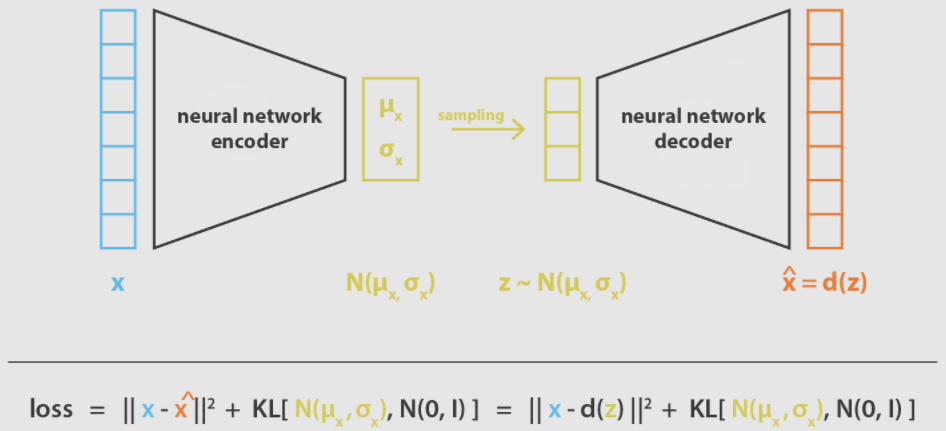

Implementing VAEs is very easy. Check [this](https://github.com/pytorch/examples/blob/master/vae/main.py) example out. If you are looking for VAE variants, check [this](https://github.com/AntixK/PyTorch-VAE) and [this](https://arxiv.org/abs/2007.03898) instead. The encoder is a network that takes an image as inputs and gives two feature vectors as output ($\mu$ and $\log \sigma^2$). We use $\log$ for the variance because we know that it is always positive (similar to what we did for the width and height for bounding boxes in YOLOv3). We will use ResNet-18 as the encoder without the last linear layer. The feature size is $512$, we will split it in half and use the first $256$ features as $\mu$ and the second $256$ features as $\log \sigma^2$. Then, we need to sample a latent vector from the normal distribution $\mathbf{\hat{z}} \sim \mathcal{N}(\mathbf{\mu}, \text{diag}(\mathbf{\sigma}))$ using a simple reparametrization trick $\mathbf{\hat{z}} = \mu + \sigma \varepsilon$ where $\varepsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{1})$. This trick is important in order be able to backpropagate the gradients back to the encoder. Finally, we use a decoder network that generate an image given a latent vector. It is worth noting that VAEs still care about the mean squared error between the generated image and the real one (as in autoencoders), therefore the ideal output of a VAE is the average image over all plausible ones.



In [ ]:
# TODO: Understand the following implementation and how does this compare to autoencoders? (3 points)
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet18()
        resnet.fc = nn.Identity()
        self.encoder = resnet
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 512, 3, stride=2),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, 3, stride=2),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 3, stride=2),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 3, stride=2),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(32, 32, 3, stride=2, output_padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(32, 16, 5, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(16, 3, 3, padding=1),
        )

    def forward(self, inputs):
        mean, logvar = self.encode(inputs)
        latent_vector = self.sample_normal(mean, logvar)
        outputs = self.decode(latent_vector)
        return outputs, mean, logvar

    def encode(self, images):
        # TODO: vvvvvvvvvvv 
        # encode the image and split the output features
        mean, logvar = ...
        # ^^^^^^^^^^^^^^^^
        return mean, logvar

    @staticmethod
    def sample_normal(mean, logvar):
        # TODO: vvvvvvvvvvv 
        # implement and understand the reparameterization trick
        z_hat = ...
        # ^^^^^^^^^^^^^^^^
        return z_hat

    def decode(self, latent_vector):
        # TODO: vvvvvvvvvvv
        # decode the latent_vector to an image
        x_hat = ...
        # ^^^^^^^^^^^^^^^^^
        return x_hat


model = VAE()
x = torch.rand(2, 3, 128, 128)
outputs, mean, logvar = model(x)
print(mean.shape)
print(logvar.shape)
print(outputs.shape)

## Task 2: Training and Evaluation

Let's write our training function but add to it [tensorboard](https://pytorch.org/docs/stable/tensorboard.html) logging support.

In [ ]:
# https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks
log_dir = Path('./runs')
log_dir.mkdir(exist_ok=True)
tensorboard.notebook.start(f'--logdir={log_dir} --bind_all')

# if you don't see tensorboard here, you can open it in a new browser tab
# in rare cases, you might need to consider using ngrok: https://ngrok.com/
tensorboard.notebook.list()
!hostname -I  # use this ip with port above

In [ ]:
def train(model, loader, optimizer, device, beta=1, epochs=5, show_every=50):
    model.train(True)
    num_batches = len(loader)
    writer = SummaryWriter(log_dir=None)  # use the default log_dir=./runs
    for epoch in range(epochs):
        loss_sum = count = 0
        for i, images in enumerate(tqdm(loader), 1):
            images = images.to(device)
            outputs, mean, logvar = model(images)

            # assuming Gaussian:
            recon_term = F.mse_loss(outputs.sigmoid(), images)
            # assuming Bernoulli:
            # recon_term = F.binary_cross_entropy_with_logits(outputs, images)

            # constants don't affect the gradients (change the learning rate)
            reg_term = (mean**2 + logvar.exp() - logvar).mean() - 1

            # TODO: vvvvvvvvvvv (0.5 points)
            # why do we multiply beta by this factor? (check the loss formula)
            # factor = latent_dim / image_size
            factor = mean.shape[-1] / images.shape[1:].numel()
            # ^^^^^^^^^^^^^^^^^
            loss = recon_term + (beta * factor) * reg_term

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            count += len(images)
            loss_sum += recon_term.item() * len(images)

            step = epoch * num_batches + i - 1
            writer.add_scalar('loss/train', loss.item(), step)
            writer.add_scalar('recon_term/train', recon_term.item(), step)
            writer.add_scalar('reg_term/train', reg_term.item(), step)

            last_iteration = i == len(loader)
            if i % show_every == 0 or last_iteration:
                fig = plt.figure()
                ax = fig.add_subplot()
                grid = torch.stack([images[:8], outputs.data[:8].sigmoid()])
                grid = grid.transpose(0, 1).flatten(0, 1)
                grid = torchvision.utils.make_grid(grid)
                writer.add_image('images', grid, step)
                ax.imshow(TF.to_pil_image(grid))
                ax.set_title(f'Epoch {epoch}: Loss = {loss_sum / count:.5f}')
                ax.axis('off')
                plt.show(fig)
        # writer.add_graph(model.eval(), images)
        writer.close()

In [ ]:
device = torch.device('cuda:0')
loader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=device.type == 'cuda',
    drop_last=True,
)
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters())
train(model, loader, optimizer, device, beta=1, epochs=5, show_every=50)

Hopefully, after some tinkering you got the training loss to reach a point where you can see [reasonable](https://arxiv.org/abs/1906.01984) results. However, is the loss the best metric we can use to evalute our generative model? Well, other metrics [exists](http://proceedings.mlr.press/v84/chen18e.html) such as the Frechet distance. The idea behind it is very simple. It uses the [Frechet distance](https://www.sciencedirect.com/science/article/pii/0047259X8290077X) between two Multivariate Gaussian distributions. The first distribution is inferred from the dataset while the second is from generated samples of our model. Instead of working on raw images we usually work with extracted features of these images (a common backbone is the [inception model](https://pytorch.org/vision/stable/models.html#inception-v3); see [FID score](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance)). We will use [ResNet-18](https://pytorch.org/vision/stable/models.html#id3) here instead.

In [ ]:
class FrechetDistance:
    """Frechet's distance between two multi-variate Gaussians
    https://www.sciencedirect.com/science/article/pii/0047259X8290077X
    """
    def __init__(self, double=True, num_iterations=20, eps=1e-12):
        self.eps = eps
        self.double = double
        self.num_iterations = num_iterations

    def __call__(self, normal1, normal2):
        # make sure that both of them have unbiased set the same
        mu1, sigma1 = normal1.mean, normal1.covariance_matrix
        mu2, sigma2 = normal2.mean, normal2.covariance_matrix
        return self.compute(mu1, sigma1, mu2, sigma2)

    def compute(self, mu1, sigma1, mu2, sigma2):
        """Compute Frechet's distance between two multi-variate Gaussians
        https://gist.github.com/ModarTensai/185ca53b35b012c7fe781e4c567378a6
        """
        norm_2 = (mu1 - mu2).norm(2, dim=-1).pow(2)
        trace1 = sigma1.diagonal(0, -1, -2).sum(-1)
        trace2 = sigma2.diagonal(0, -1, -2).sum(-1)
        sigma3 = self.psd_matrix_sqrt(sigma1 @ sigma2)
        trace3 = sigma3.diagonal(0, -1, -2).sum(-1)
        return norm_2 + trace1 + trace2 - 2 * trace3

    def psd_matrix_sqrt(self, matrix):
        """Compute the square root of a PSD matrix using Newton's method
        https://gist.github.com/ModarTensai/7c4aeb3d75bf1e0ab99b24cf2b3b37a3
        """
        dtype = matrix.dtype
        if self.double:
            matrix = matrix.double()
        norm = matrix.norm(dim=[-2, -1], keepdim=True).clamp_min_(self.eps)
        matrix = matrix / norm

        def mul_diag_add(inputs, scale=-0.5, diag=1.5):
            # multiply by a scalar then add a scalar to the diagonal
            inputs.mul_(scale).diagonal(0, -1, -2).add_(diag)
            return inputs

        other = mul_diag_add(matrix.clone())  # avoid inplace
        matrix = matrix @ other
        for i in range(1, self.num_iterations):
            temp = mul_diag_add(other @ matrix)
            matrix = matrix @ temp
            if i + 1 < self.num_iterations:  # skip last step
                other = temp @ other
        return (matrix * norm.sqrt()).to(dtype)

Let's create a class that can accumulate the statistics of a stream of batches; the first two moments (mean $\mathbf{\mu}$ and covariance matrix $\mathbf{\Sigma}$).

```python
gaussian = MultivariateNormal(feature_size=5)

data = torch.randn(2000, gaussian.feature_size)
for batch in data.chunk(100):
    gaussian(batch)  # accumulate stats over the batches

# compute the stats on the entire data
mean = data.mean(0)
covariance_matrix = (data - mean).T.conj() @ (data - mean) / (len(data) - 1)

# compare the streamed stats to the full stats
print(torch.allclose(gaussian.mean, mean))
print(torch.allclose(gaussian.covariance_matrix, covariance_matrix))
```

In [ ]:
class MultivariateNormal(nn.Module):
    """Multivariate normal (also called Gaussian) distribution
    https://gist.github.com/ModarTensai/185ca53b35b012c7fe781e4c567378a6
    """
    def __init__(self, feature_size, unbiased=True):
        super().__init__()
        self.count = 0
        self.unbiased = bool(unbiased)
        self.feature_size = feature_size
        mean = torch.zeros(self.feature_size)
        mass = torch.zeros(self.feature_size, self.feature_size)
        self.register_buffer('mean', mean)
        self.register_buffer('mass', mass)

    @property
    def factor(self):
        """Get the normalization factor"""
        return 1 / (self.count - int(bool(self.unbiased)))

    @property
    def covariance_matrix(self):
        """Get the covariance matrix"""
        return self.mass * self.factor

    @property
    def variance(self):
        """Get the variance."""
        return self.mass.diag() * self.factor

    def forward(self, batch):
        """Perform the forward pass (only update in training mode)"""
        mean, covariance, count = self.get_stats(batch, self.unbiased)
        if self.training:
            self.stats_update(mean, covariance, count, self.unbiased)
        return mean, covariance

    @staticmethod
    def get_stats(batch, unbiased=True):
        """Compute the statistics of a batch
        https://gist.github.com/ModarTensai/5ab449acba9df1a26c12060240773110
        """
        assert 1 <= batch.ndim <= 2
        if batch.ndim == 1:
            batch.unsqueeze(0)
        count = batch.shape[0]
        mean = batch.mean(0)
        if count == 1:
            covariance = None
        else:
            batch = batch - mean
            factor = 1 / (count - int(bool(unbiased)))
            covariance = factor * batch.t().conj() @ batch
        return mean, covariance, count

    def stats_update(self, mean, covariance, count, unbiased=None):
        """Update the model given batch statistics
        https://gist.github.com/ModarTensai/dc95444faf3624ed979b4d0b2088fdf1
        """
        diff1 = mean - self.mean
        self.mean += diff1 * (count / (self.count + count))
        diff2 = mean - self.mean
        mass = diff1[:, None] @ diff2[None, :]
        if count > 1:
            mass += covariance
            mass *= count
            if unbiased is None:
                unbiased = self.unbiased
            if unbiased:
                mass -= covariance
        self.mass += mass
        self.count += count

We will use `MultivariateNormal` to fit a multivariate Gaussian distribution $\mathcal{N}(\mathbf{\mu}, \mathbf{\Sigma})$ to our generated images. We will also do the same and fit another multivariate Gaussian distribution to the ground truth dataset. Finally, we will compute the Frechet distance between them.

In [ ]:
def evaluate(model, loader, device):
    model.train(False)
    batch_size = loader.batch_size
    latent_dim = model.decoder[0].in_channels

    # get the distance and feature extractor
    frechet_distance = FrechetDistance()
    feature_extractor = torchvision.models.resnet18(pretrained=True)
    feature_extractor.to(device).eval().requires_grad_(False)
    feature_size = feature_extractor.fc.in_features
    feature_extractor.fc = nn.Identity()

    # compute the stats of the dataset
    dataset_distribution = MultivariateNormal(feature_size).to(device)
    # with torch.no_grad():  # is this needed?
    for image_batch in tqdm(loader):
        features = feature_extractor(image_batch.to(device))
        dataset_distribution(features)

    # compute the stats of the model
    model_distribution = MultivariateNormal(feature_size).to(device)
    with torch.no_grad():
        for _ in tqdm(range(len(loader))):
            latent_vector = torch.randn(batch_size, latent_dim, device=device)
            image_batch = model.decode(latent_vector)
            features = feature_extractor(image_batch)
            model_distribution(features)

    return frechet_distance(model_distribution, dataset_distribution)


distance = evaluate(model, loader, device)
print(f'Frechet ResNet18 Distance = {distance:.3f} (lower is better)')

Now, it is your turn to put these utilities in use.

In [ ]:
# TODO: vvvvvvvvvvv (2 points)
# copy `train()` here and do the following changes:
# - print the Frechet distance (FD) at every epoch similar to `evaluate()`
# - don't use `evaluate()` directly as it is inefficient
#   you don't need to load the feature extractor at each epoch
#   make sure to compute `dataset_distribution` only once (when `epoch == 0`)
# - compute `vae_distribution` on the reconstructed images instead
#   this is for simplicity; in practice, we should use generated images
#   generated_images = decoder(random_latent_vector)
#   reconstructed_images = decoder(sample(encoder(real_image)))
# - be careful to set the models in eval and train mode appropriately if needed
# - avoid gradients if required to prevent memory leaks (out of memory errors)
def train(model, loader, optimizer, device, beta=1, epochs=5, show_every=50):
    ...
# ^^^^^^^^^^^^^^^^^

train(model, loader, optimizer, device, beta=1, epochs=5, show_every=50)

Check the state-of-the-art (SOTA) [results](https://paperswithcode.com/sota/image-generation-on-ffhq-256-x-256) on a bigger version of this dataset.

## Task 3: Visualization

Let's take two images and visualize few interpolation steps between them in the latent space.

In [ ]:
#@title  { run: "auto", vertical-output: true, display-mode: "both" }
def interpolate(x, y, count, spherical=False):
    """Interpolate between two feature vectors.

    Args:
        x: tensor of shape [N, F]
        y: tensor of shape [N, F]
        count: number of interpolation steps
        spherical: whether to do spherical or linear interpolation

    Returns:
        tensor of shape [N, count, F]
    """
    alphas = torch.linspace(0, 1, count, device=x.device)
    if spherical:
        # https://en.wikipedia.org/wiki/Slerp
        omega = torch.cosine_similarity(x, y, dim=-1).arccos().unsqueeze(-1)
        factor = lambda x: (x * omega).sin()
        out = torch.stack([factor(1 - a) * x + factor(a) * y for a in alphas])
        out = out / omega.sin()
    else:
        # https://en.wikipedia.org/wiki/Linear_interpolation
        # TODO: Understand the solve the part below (0.5 points)
        # apply linear interpolation between x and y given alphas
        # you can either do it manually and stack or use torch.lerp
        out = ...
        # ^^^^^^^^^^^^^^^^^
    return out.transpose(0, 1)


@torch.no_grad()
def sweep(model, images, count=8, spherical=False, stitch=True, grid=True):
    """Generate interpolations between images in the latent space"""
    assert len(images) % 2 == 0, 'should be an even number of images'
    model.train(False)
    latent = model.sample_normal(*model.encode(images))

    count -= 2 if stitch else 0
    latent = interpolate(*latent.chunk(2), count, spherical)
    output = model.decode(latent.flatten(0, 1)).sigmoid()
    output = TF.resize(output, output.shape[-1] // 2)
    output = output.view(-1, count, *output.shape[1:])
    count += 2 if stitch else 0

    if stitch:
        images = TF.resize(images, images.shape[-1] // 2)
        images = images.view(2, -1, *images.shape[1:]).transpose(0, 1)
        start, end = images.chunk(2, dim=1)
        output = torch.cat([start, output, end], dim=1)

    if grid:
        output = torchvision.utils.make_grid(output.flatten(0, 1), count)
    return output


num_rows = 3 #@param {type:"slider", min:1, max:10, step:1}
indices = torch.randint(len(dataset), (2 * num_rows,))
images = torch.stack([dataset[i] for i in indices]).to(device)

num_columns = 8 #@param {type:"slider", min:1, max:10, step:1}
TF.to_pil_image(sweep(model, images, num_columns, spherical=False))

<h2>Conditional VAEs</h2>

So far, we don't have control over the output and we don't know what every feature in the latent vector mean. We can investigate the latent space by sampling and then increasing/decreasing the value of every feature (out of the $256$ features) independently and see how this affects the generated image. But this is after the fact. Can we somehow have a finer control over this? Read up on [disentangled representation learning](https://deepai.org/machine-learning-glossary-and-terms/disentangled-representation-learning). Another common trick is to modify our model to be **conditional**. Consider passing a secondary condition $\mathbf{y}$ (e.g., label) as input to the encoder and the decoder. We define what this condition represent (e.g., female/male, young/old, ...) but it comes at a cost of extra supervision (we need to know these details about the images). The final model is now called a Conditional Variational Auto-Encoder ([CVAE](https://towardsdatascience.com/understanding-conditional-variational-autoencoders-cd62b4f57bf8)).

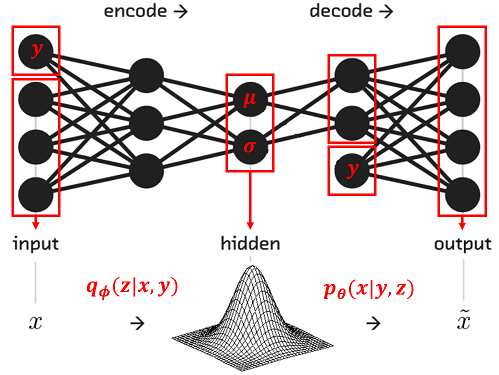

# Part 2: Generative Adversarial Networks (13 points)

Another type of latent-based generative models is the Generative Adversarial Network (GAN). Unlike VAEs, GANs don't model the data distribution explicitly. They don't have an encoder (image $\rightarrow$ latent vector). Instead, they use a discriminator model $D(\mathbf{x})$ that guide the decoder (here called the generator $G(\mathbf{z})$) to generate samples that are closer to the real distribution. The discriminator is just a binary image classifer with a single scalar output classifying whether an input image is real or fake (generated). So, the generator starts at the begining of training with generating random images and the discriminator tells it how realistic are they. To train the discriminator to differentiate real from fake, we will use the generated images as fake samples and images from the dataset as real samples then train it with them. This process will repeat iteratively (i.e., train the discriminator with real and fake samples for few iterations then train the generator using the discriminator). One way to look at this is to view them as adversaries (enemies) that try to outsmart each other (hence, the name).

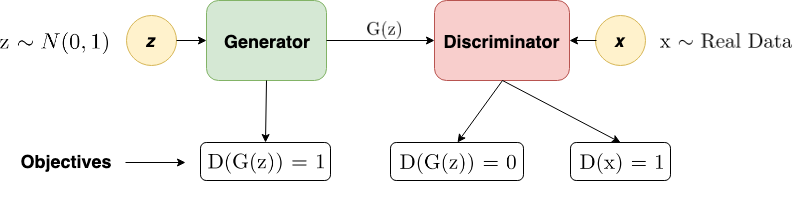

The final objective can be written as a min-max problem:

$$\min_G \max_D \mathbb{E}_{\mathbf{x} \sim p(\mathbf{x})}[\log D(\mathbf{x})] + \mathbb{E}_{\mathbf{z} \sim p(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))]$$

We can split this into two loss functions; one for the generator and the other for the discriminator:

$$\begin{align}
\mathcal{L}^\text{GAN}_G(\mathbf{z}) &= \mathbb{E}_{\mathbf{z} \sim p(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))] \\
\mathcal{L}^\text{GAN}_D(\mathbf{x}) &= -\mathbb{E}_{\mathbf{x} \sim p(\mathbf{x})}[\log D(\mathbf{x})] - \mathbb{E}_{\mathbf{z} \sim p(\mathbf{z})}[\log(1 - D(G(\mathbf{z})))] \\
\end{align}$$

Assuming the output of $D(\mathbf{x})$ is in the range $[0, 1]$ (e.g., uses Sigmoid) and without loss of generality, the generator wants to fool the discriminator (i.e., $D(G(\mathbf{z}))$ should be close to $1$) while the discriminator wants to differentiate between real and fake images (i.e., $D(x)$ shoule be close to $1$ while $D(G(\mathbf{z}))$ should be close to $0$). This is the first time where we needed to modify our training procedure manually.

Study [this](https://github.com/pytorch/examples/blob/6c8e2bab4d45f2386929c83bb4480c18d2b660fd/dcgan/main.py#L205-L273) example to see how they are implemented in practice. There are other GAN variants out there you can check some of them [here](https://github.com/eriklindernoren/PyTorch-GAN).

Before you start take a look at the concepts of [mode collapse](https://cedar.buffalo.edu/~srihari/CSE676/22.3-GAN%20Mode%20Collapse.pdf) and [GAN metrics](https://machinelearningmastery.com/how-to-evaluate-generative-adversarial-networks/).

[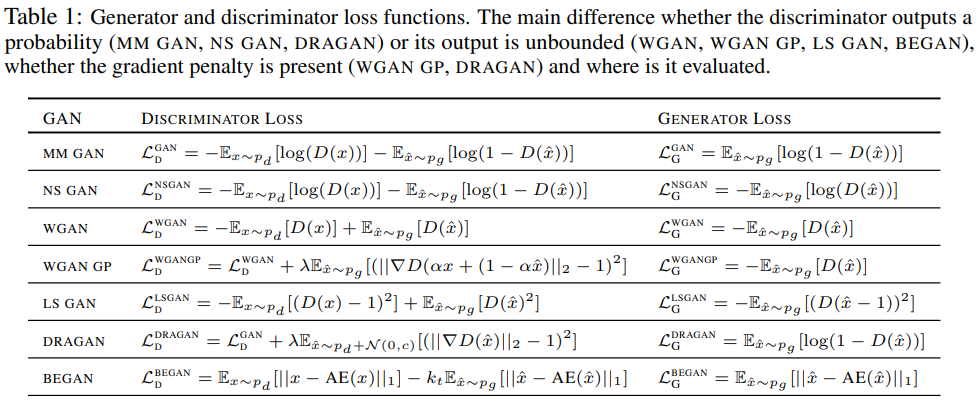](https://papers.nips.cc/paper/2018/file/e46de7e1bcaaced9a54f1e9d0d2f800d-Paper.pdf)

<!-- Gordon's part starts here with some refactoring -->

In this part, we are going to implement a conditional version of the Deep Convolutional Generative Adversarial Network ([DCGAN](https://arxiv.org/abs/1511.06434)) on [MNIST](http://yann.lecun.com/exdb/mnist/) since we have the labels. We expect the model to generate hand written digits given input conditions. The outputs of Conditional DCGAN with different conditions (from $0$ to $9$, in each coloum) should look like the following (each image is an example):

In [ ]:
#@title  { run: "auto", vertical-output: true, display-mode: "both" }
def visualize_mnist(root_dir, num_examples=5):
    mnist = torchvision.datasets.MNIST(root_dir, download=True)
    labels = [label[4:] for label in mnist.classes]
    index = iter(torch.randperm(len(mnist)))

    rows, cols = num_examples, len(labels)
    fig, axes = plt.subplots(rows, cols, dpi=100)
    for col in range(cols):
        for row in range(rows):
            label = -1
            while label != col:
                # don't worry, we will never run out ;)
                image, label = mnist[next(index)]
            ax = axes[row][col]
            ax.imshow(image, cmap='gray')
            ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            if row == 0:
                ax.set_title(labels[col])
            # if col == 0:
            #     ax.set_ylabel(f'{row + 1}')
    fig.tight_layout()
    plt.show(fig)


num_examples = 5 #@param {type:"slider", min:2, max:10, step:1}
mnist_root = Path(torch.hub.get_dir()) / 'datasets/MNIST'
visualize_mnist(mnist_root, num_examples)

## Task 1: Model Construction

Implement the **Conditional DCGAN Generator** for images of size $1 \times 32 \times 32$ (we will upsample MNIST):

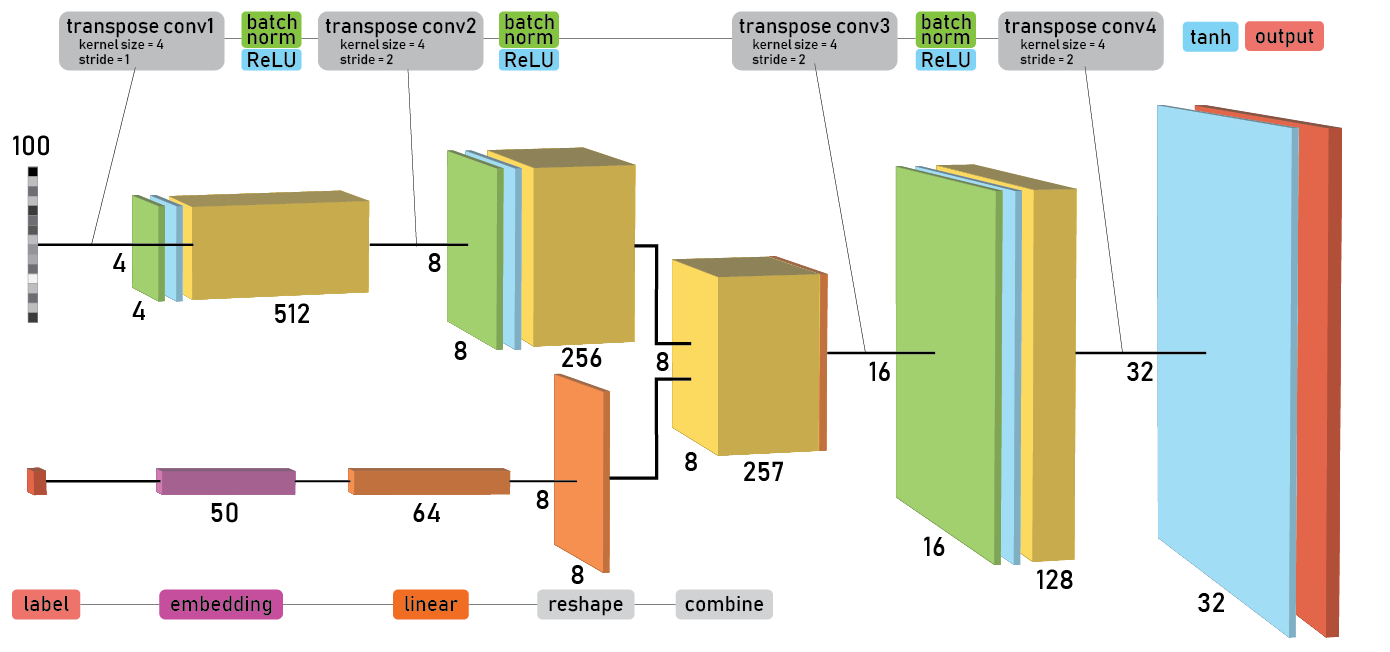

In [ ]:
# TODO:  vvvvvvvvvvv (3 points)
# implement the generator network for C-DCGAN as in the figure 
# generate a random batch to be passed to the generator 
# answer the following from the paper and/or the figure:
# - what is the input in the top branch (the vector with size 100)?
# - what is input in the bottom branch?
# - what does the embedding layer do?
# - what does the transpose conv do?
class CondGenerator(nn.Module):
    def __init__(self, latent_dim, num_channels, num_classes):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.num_channels = num_channels
        ...

    def forward(self, latent_vector, label):
        ...
    
    def random_batch(self, batch_size):
        device = next(generator.parameters()).device
        latent = ...
        label = ...
        return latent, label
# ^^^^^^^^^^^^^^^^^


batch_size = 2
latent_dim = 100
num_channels = 1
num_classes = 10
device = torch.device('cuda:0')
generator = CondGenerator(latent_dim, num_channels, num_classes).to(device)

# test your implementation by doing a single forward pass using random inputs
latent_vector, labels = generator.random_batch(batch_size)
print(generator(latent_vector, labels).shape)

Implement the **Conditional DCGAN Discriminator** as the following:

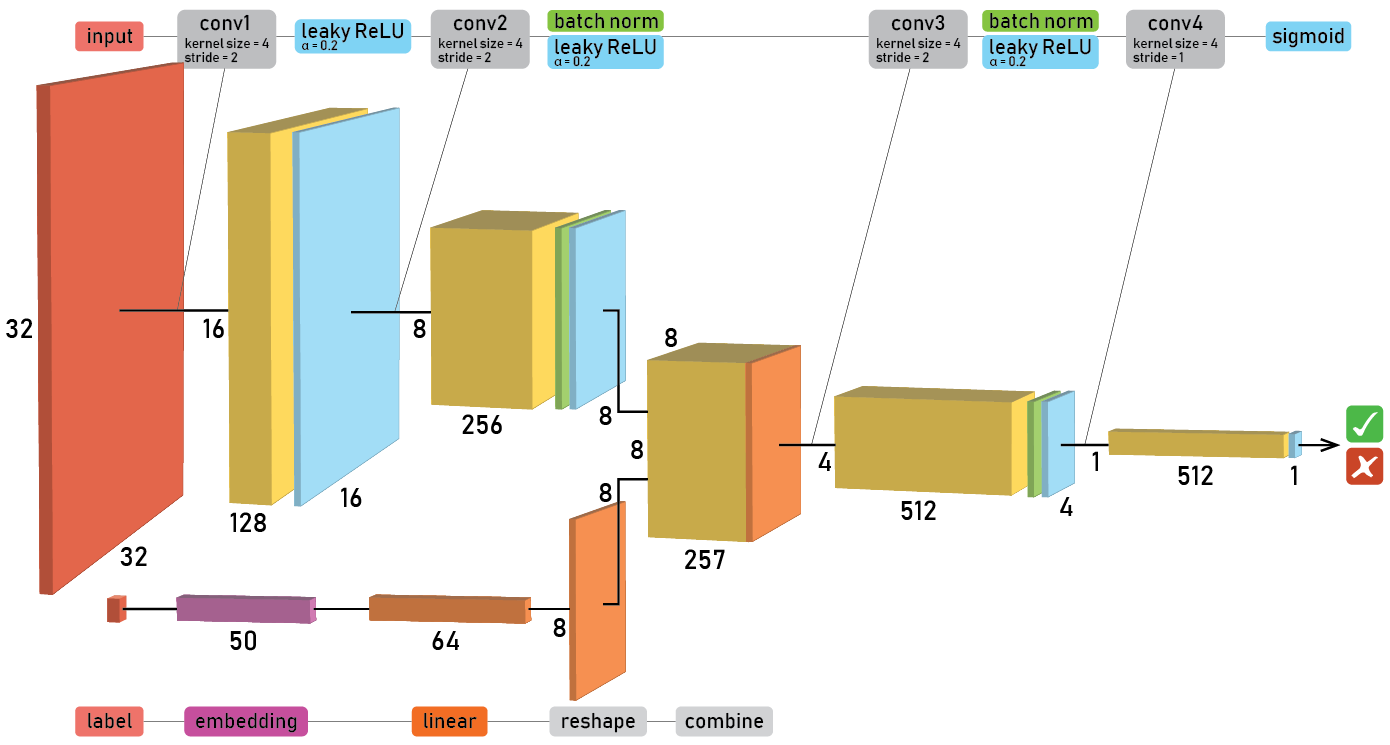

In [ ]:
# TODO: vvvvvvvvvvv (2 points)
# implement the discriminator network for C-DCGAN as in the figure
# however, don't use sigmoid here (leave it to the training function)
# answer the following from the paper and/or the figure:
# 1. what is the usage of the discriminator? 
# 2. what is the output of the discriminator?
class CondDiscriminator(nn.Module):
    def __init__(self, num_channels, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.num_channels = num_channels
        ...

    def forward(self, image, label):
        ...
# ^^^^^^^^^^^^^^^^^


discriminator = CondDiscriminator(num_channels, num_classes).to(device)
# test your implementation by doing a single forward pass using random inputs
latent_vector, label = generator.random_batch(batch_size)
image = generator(latent_vector, labels)
print(discriminator(image, label).shape)
# ^^^^^^^^^^^^^^^^^

Once we have both the generator and the discriminator, let's initialize their weights as described in the [paper](https://arxiv.org/abs/1511.06434) (Section 4).

In [ ]:
def weight_initialization(module):
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
        # TODO: vvvvvvvvvvv (0.5 points)
        # use the same initialization as mentioned in the paper
        ...
        # ^^^^^^^^^^^^^^^^^
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.normal_(module.weight, 1.0, 0.02)
        nn.init.zeros_(module.bias)


generator.apply(weight_initialization)
discriminator.apply(weight_initialization)
print('Done!')

## Task 2: Training and Evaluation

In [ ]:
def train(generator,
          discriminator,
          loader,
          generator_optimizer,
          discriminator_optimizer,
          device,
          epochs=5,
          show_every=50):
    generator.train(True)
    discriminator.train(True)

    criterion = F.binary_cross_entropy_with_logits
    as_real = lambda x: criterion(x, torch.ones_like(x))
    as_fake = lambda x: criterion(x, torch.zeros_like(x))

    num_classes = generator.num_classes
    num_batches = len(loader)
    writer = SummaryWriter(log_dir=None)  # use the default log_dir=./runs
    for epoch in range(epochs):
        loss_sum = count = 0
        for i, (real, real_labels) in enumerate(tqdm(loader), 1):
            real, real_labels = real.to(device), real_labels.to(device)

            # generate fake images
            latent, fake_labels = generator.random_batch(len(real))
            fake = generator(latent, fake_labels)

            # TODO: vvvvvvvvvvv (4 points)
            # Understand and solve the following
            # compute the loss and update the discriminator **only**
            # maximize log(D(x)) + log(1 - D(G(z)))
            # understand how well the discriminator should perform at the global optimum

            d_loss = ...
            d_loss.backward(retain_graph=True)
            discriminator_optimizer.step()

            # compute the loss and update the generator **only**
            # maximize log(D(G(z)))
            
            g_loss = ...
            generator.zero_grad()
            g_loss.backward(retain_graph=False)
            generator_optimizer.step()
            # ^^^^^^^^^^^^^^^^^

            count += len(fake)
            loss_sum += g_loss.item() * len(fake)

            step = epoch * num_batches + i - 1
            writer.add_scalar('D_loss/train', d_loss.item(), step)
            writer.add_scalar('G_loss/train', g_loss.item(), step)

            last_iteration = i == len(loader)
            if i % show_every == 0 or last_iteration:
                fig = plt.figure()
                ax = fig.add_subplot()
                grid = (fake.data[:16] + 1) * 0.5
                grid = torchvision.utils.make_grid(grid)
                writer.add_image('images', grid, step)
                ax.imshow(TF.to_pil_image(grid))
                ax.set_title(f'Epoch {epoch}: Loss = {loss_sum / count:.5f}')
                ax.axis('off')
                plt.show(fig)
        writer.close()

In [ ]:
# TODO: vvvvvvvvvvv (0.5 points)
# load and prepare the MNIST dataset to be ready for training
# use the recommended setup as in Section 4 in the paper
transform = T.Compose([...])
dataset = torchvision.datasets.MNIST(...)
loader = torch.utils.data.DataLoader(...)
generator_optimizer = ...
discriminator_optimizer = ...
train(generator, discriminator, loader, generator_optimizer,
      discriminator_optimizer, device, epochs=20, show_every=50)
# ^^^^^^^^^^^^^^^^^

Let's visualize an example for each digit (conditionally).

In [ ]:
generator.train(False)
with torch.no_grad():
    # TODO: vvvvvvvvvvv (1 points)
    # create a label for each digit with an accompanying latent vector
    latent = ...
    label = ...
    # ^^^^^^^^^^^^^^^^^
    image = torchvision.utils.make_grid(generator(latent, label), 10)
TF.to_pil_image(TF.resize((image + 1) * 0.5, 64))

<!-- Gordon's part ends here -->

## Task 3: Network Inversion

Since GANs don't have an encoder, let's invert the generator (i.e., find the latent vector that generate the closet output to a given image). The idea is very simple, do gradient descent on the latent vector. Start with a randomly generated vector $\mathbf{z}$. Then, compute a reconstruction loss (e.g., MSE) to the given image. Compute the gradient of the loss with respect to $\mathbf{z}$ using backpropagation ([`torch.autograd.backward()`](https://pytorch.org/docs/stable/autograd.html#torch.autograd.backward) or [`torch.autograd.grad()`](https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad)). The only issue with this, is that you have to provide the label as well because it is not differentiable. However, if you insist, we can use the embedding instead then choose the label with the closest embedding to the final solution.

In [ ]:
def invert(model, images, labels, lr, steps):
    model.train(False)
    latent_dim = model.latent_dim
    latent = torch.randn(len(images), latent_dim, device=images.device)
    latent.requires_grad_(True)
    for _ in tqdm(range(steps)):
        outputs = model(latent, labels)
        # TODO: vvvvvvvvvvv (1 points)
        # compute the needed gradient
        loss = ...
        grad = ...
        loss.backward()
        # ^^^^^^^^^^^^^^^^^
        latent.data -= lr * grad
    latent.requires_grad_(False)
    grid = torch.stack([images, outputs.data])
    grid = grid.transpose(0, 1).flatten(0, 1)
    grid = torchvision.utils.make_grid((grid + 1) * 0.5)
    return latent, grid


indices = torch.randint(len(dataset), (8,))
image, label = zip(*[dataset[i] for i in indices])
image, label = torch.stack(image).to(device), torch.tensor(label).to(device)
# TODO: vvvvvvvvvv (1 points)
# adjust the hyper parameters until you get reasonable results
latent, output = invert(generator, image, label, lr=1e-1, steps=3)
TF.to_pil_image(TF.resize(output, 128))
# ^^^^^^^^^^^^^^^^^

# Part 3: Adversarial Attacks (bonus: 6 points)

> This part is the bonus. If you finish this part correctly, you will get extra points and the maximum points of whole project is 20 points.

Another application of network inversion is adversarial attacks which was first uncovered in "[Intriguing Properties of Neural Networks](https://arxiv.org/abs/1312.6199)". The paper showed that adding some engineered noise which we refer to as an "adversarial perturbation" could cause the network to misclassify the input. Adversarial attacks could either be targeted where we want to flip the classifier's prediction into a particular class label $t$ or untargeted where we simply want the classifier to misclassify the input sample as any other class. Below we show an example of a dog image which is misclassified as an ostrich upon adding the adversarial perturbation.

<!-- Codes by HTML.am -->

<!-- CSS Code -->
<style type="text/css" scoped>
img.GeneratedImage {
width:700px;height:300px;margin:10px;border-width:6px;border-color:#000000;border-style:solid;
}
</style>

<!-- HTML Code -->
<img src="https://miro.medium.com/max/700/1*8gHcUx1pKwxb0A6lze9tOw.jpeg" alt="Photo of the Remarkables mountain range in Queenstown, New Zealand." class="GeneratedImage">


Now the main question is: How do we generate these adversarial perturbations? Optimization is the answer! For a targeted attack, we want to minimize the loss function (cross entropy) between the network's prediction and the target label $$\min_{\delta}\mathcal{L}(f_\theta(x+\delta), t)$$ For the untargeted scenario, we want to maximize the loss function between the network's prediction and the ground truth label, that is we want the network to be penalized if it predicts the input as the correct label $$\max_{\delta}\mathcal{L}(f_\theta(x+\delta), y)$$

In both scenarios, the attacker wants their perturbation to be impercetible under human inspection; otherwise, the attack can easily be detected! How do we ensure that? By having a norm constraint for the optimization problem! We can bound the adversarial perturbation $\delta$ into an $\ell_p$ ball by imposing the following constraint: $$\Delta = \{ \delta \in \mathbb{R}^d : \|\delta\|_p \leq \epsilon \}, \epsilon>0$$

A very simple solution to this problem is offered by Fast Sign Gradient Method (FGSM) ([1](https://towardsdatascience.com/adversarial-attack-and-defense-on-neural-networks-in-pytorch-82b5bcd9171), [2](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)): $$\tilde{x} = x + \epsilon * sign(\nabla_x \mathcal{L}(\theta, x, y))$$ where $\tilde{x}$ is our attacked image, $\epsilon$ is our norm budget (radius of our $\ell$-ball) and sign is +1 for a non-negative value and -1 otherwise.

### Single Image - Untargeted Attack

In [ ]:
# We will implement a simple adversarial attack on a pretrained ResNet18 on CIFAR10.
# We first load the model in our model in memory/GPU depending on the availability a GPU.

net = torch.load("./ResNet18.pth").eval()
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# We load CIFAR10 data and transform the images from PIL to tensor.
transform_test = T.Compose([
    T.ToTensor(),
])

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=16, shuffle=False, num_workers=2)

# Names of classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')



In [ ]:
# Let us visualize some of CIFAR10 images
images, labels = next(iter(testloader))
grid_img = torchvision.utils.make_grid(images, nrow=8)
fig = plt.figure(figsize=(12,12),dpi=100)
plt.imshow(grid_img.permute(1,2,0))


In [ ]:
# Clone a copy of the first image in the batch
# TODO: Understand why we have to clone the image

x_pert = images[0].clone()
epsilon = torch.zeros(3,32,32)

# To optimize for epsilon we have to turn on the gradients for this variable
print("Does Epsilon Require Gradient Computation?", epsilon.requires_grad)

####
#TODO: Activate gradient computation for epsilon
# Understand why we have to turn on the gradients for epsilon
...

####

print("Does Epsilon Require Gradient Computation?", epsilon.requires_grad)

# Let us check the class of the input image
print("Input Image Class:", classes[labels[0]])

In [ ]:
# We will now implement a very simplistic attack on a single image
# We will use an optimizer and control the step size by the learning rate lr. 
# To implement a simple version of FGSM we take a single step of size = lr 

#TODO: Pass the correct arguments to the optimizer parameters
# Control lr to find an adversary and attain an imperceptible image

optimizer = torch.optim.Adam(params = ..., lr=...)

# We remember we always reset our gradients to 0 
optimizer.zero_grad()

# Forward pass
prediction = net((x_pert+epsilon).unsqueeze(0).to(device))

# Backprop and update epsilon
criterion = torch.nn.CrossEntropyLoss() 
loss = -criterion(prediction, labels[0].unsqueeze(0).to(device))

loss.backward()
optimizer.step()

# Take the perturbed image and forward pass
attackedimage = x_pert+epsilon
prediction = net(attackedimage.unsqueeze(0).to(device))

# Check the class and visualize the new image
print("New Prediction:", classes[prediction.argmax(1)])
print("ell-2 Norm of the Attack:" ,torch.norm(attackedimage-x_pert,2).item())
plt.imshow(x_pert.permute(1,2,0).detach().cpu())


### Single Image - Targeted Attack
We now repeat the earlier process but instead of carrying out an untargeted attack (where we maximize the loss between the network's prediction and the class label) we now need to do a targeted attack. 

We first repeat the data processing carried out in the earlier cell

In [ ]:
# Clone a copy of the first image in the batch
# TODO: Understand why we have to clone the image

x_pert = images[0].clone()
epsilon = torch.zeros(3,32,32)

# To optimize for epsilon we have to turn on the gradients for this variable
print("Does Epsilon Require Gradient Computation?", epsilon.requires_grad)

####
#TODO: Activate gradient computation for epsilon
# Understand why we have to turn on the gradients for epsilon
...

####

print("Does Epsilon Require Gradient Computation?", epsilon.requires_grad)

# Let us check the class of the input image
print("Input Image Class:", classes[labels[0]])

In [ ]:
# We will now implement a very simplistic attack on a single image
# We will use an optimizer and control the step size by the learning rate lr. 
# To implement a simple version of FGSM we take a single step of size = lr 
# Let us set lr = 0.05

#TODO: Pass the correct arguments to the optimizer parameters
# Control lr to find an adversary and attain an imperceptible image

optimizer = torch.optim.Adam(params = ..., lr=...)

optimizer.zero_grad()

prediction = net((x_pert+epsilon).unsqueeze(0).cuda())
criterion = torch.nn.CrossEntropyLoss()

#TODO: Fill in the loss for targeted attack. Let us predict the cat image as a truck.
# Please do experiment with multiple classes and multiple input images to better understand what's happening

loss = ...

loss.backward()
optimizer.step()

attackedimage = x_pert+epsilon
prediction = net(attackedimage.unsqueeze(0).cuda())

print("New Prediction:", classes[prediction.argmax(1)])
print("ell-2 Norm of the Attack:" ,torch.norm(attackedimage-x_pert,2).item())
plt.imshow(x_pert.permute(1,2,0).detach().cpu())


## Batch Adversarial Attacks

In [ ]:
#TODO: Extend the earlier implementations of untargeted adversarial attacks and targeted adversarial attacks to 
# attack batches of images rather than single images.
# Use the same format as the earlier cells in implementing your attack.




###